In [27]:
# Math and Dataframes
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.ticker import PercentFormatter

# Machine Learning 
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold, KFold
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
# import verstack
# from verstack.stratified_continuous_split import scsplit

# Others
from datetime import datetime
import os
from pathlib import Path
import csv
import pickle

In [28]:
from draft import Regression_JKR, JKR_Dataset, error_fn, hertz, jkr

In [29]:
timestamp = '20230615_131656'
model_dir = 'model_{}'.format(timestamp)
# model_dir = '0MSE_RELU'
parent_dir = 'c:\\Users\\luisr\\OneDrive\\Ambiente de Trabalho\\Tese'
dir = 'JKR_models'
path = os.path.join(parent_dir, dir, model_dir)
# path = os.path.join(initial_wd, dir, model_dir)
os.chdir(path)

print(os.getcwd())

c:\Users\luisr\OneDrive\Ambiente de Trabalho\Tese\JKR_models\model_20230615_131656


In [30]:
def plot_bad_curves2(verror_list_E, verror_list_gamma, list_inputs, list_labels, test: bool):
  verror_arr_E = np.array(verror_list_E)
  verror_arr_gamma = np.array(verror_list_gamma)
  v_error_arr = np.vstack((verror_arr_E, verror_arr_gamma)).T
  bad_curves = [(i, j) for i, j in enumerate(v_error_arr) if j[0] > 15 and j[1] > 15] # Gets index and error value of all errors above 15%
  if len(bad_curves) > 5:
    bad_curves = sorted(bad_curves, key= lambda k:max(k[1]), reverse=True)[:5]
  if len(bad_curves) < 5: 
    all_curves_sorted = sorted([(i, j) for i, j in enumerate(v_error_arr)], key= lambda k:max(k[1]), reverse=True) # sorts error list, keeping i (the original index of each error value)
    for i in range(5-len(bad_curves)):
        bad_curves.append(all_curves_sorted[len(bad_curves)+i])
  plt.figure()
  for j, (i, _) in enumerate(bad_curves):
      tensor_idx = i//len(list_inputs[0])
      tensor_fts, tensor_labels = list_inputs[tensor_idx], list_labels[tensor_idx]
      plt.plot(tensor_fts[i-tensor_idx*len(list_inputs[0]),:,0].numpy(),
              tensor_fts[i-tensor_idx*len(list_inputs[0]),:,1].numpy(),
              alpha=0.75,
              label=f'$E$={round(tensor_labels[i-tensor_idx*len(list_inputs[0]),0].item(),2)} kPa, $\epsilon_E$={verror_list_E[i]: .1f}\%, '+
                    f'$\gamma$={round(tensor_labels[i-tensor_idx*len(list_inputs[0]),1].item(),2)} $\mu$J/m$^2$, $\epsilon_\gamma$={verror_list_gamma[i]: .1f}\%')
  plt.xlabel('Indentation (nm)')
  plt.ylabel('Force (nN)')
  plt.legend()
  ax = plt.axis()
  plt.axis((ax[1],ax[0],ax[2],ax[3]))
  if test:
    plt.savefig('bad_curves_test.pdf')
  else:
    plt.savefig('bad_curves_valid.pdf')

def plot_error_hist2(error_list, test: bool, E:bool, **kwargs):
  '''**kwargs: percentage of curves with errors under x%. 
              The values must be provided for errors in ascending order (error2_5 = y, error10 = z)'''
  # Define variable name to be introduced in the file name of the final plots
  if E:
    var_name = 'E'
  else:
    var_name = 'gamma'
  fig, ax = plt.subplots()
  plt.figure()
  x_values = [1, 2.5]
  error_values = list(kwargs.values())
  ax.hist(error_list, bins=20, density=True, ec='black', range=(0,5)) # to remove outliers, set parameter 'range='
  if E:
    # place title well above the graph
    ax.set_title("$E$", fontsize=16, y=1.08)
  else:
    ax.set_title("$\gamma$", fontsize=16, y=1.08)
  ax.set_xlabel("Error (\%)")
  ax.set_ylabel("Density")
  #plt.gca().yaxis.set_major_formatter(PercentFormatter(1)) # set y axis as %
  ax.yaxis.set_major_formatter(PercentFormatter(1))
  if test:
    ax.axvline(x_values[0], color='red', linestyle='--', label=f'{error_values[0]*100: .1f}\% of curves with $\epsilon<1\%$')
    ax.axvline(x_values[1], color='green', linestyle='--', label=f'{error_values[1]*100: .1f}\% of curves with $\epsilon<2.5\%$')
    ax.legend(loc='center', ncol=2, bbox_to_anchor=(0.5, 1.05), fontsize=13)
    ax.text(0.76, 0.95, f'Num. of tested curves: {len(error_list)}', transform=ax.transAxes, fontsize=12, ha='center', bbox=dict(boxstyle='round', facecolor='white', edgecolor='black'))
    # ax.set_title("Test error")
    fig.savefig(f'error_hist_test_{var_name}.pdf')
  else:
    fig.savefig(f'error_hist_valid_{var_name}.pdf') 
  plt.show()

def plot_pred_real_curves2(verror_list_E, verror_list_gamma, list_inputs, list_labels, test: bool, list_predicts, nu, r, E:bool):
  ''' Takes the list of errors and plots the curves with errors above 15%, and close to 10% and 2.5%.
      If plotting E, the list of errors for E is used, and only curves with gamma error below 2% are considered (and vice-versa).
      Inputs:
        - verror_list_E: list of errors for E 
        - verror_list_gamma: list of errors for gamma
        - list_inputs: list of tensors with inputs
        - list_labels: list of tensors with labels
        - test: boolean, True if test set, False if validation set
        - list_predicts: list of tensors with predictions
        - nu: Poisson's ratio
        - r: radius of the tip
        - E: boolean, True if plotting E, False if plotting gamma  
  '''
  if E:
    var_name = 'E'
    idx = 0
    verror_list = verror_list_E
    verror_list2 = verror_list_gamma
  else:
    var_name = 'gamma'
    idx = 1
    verror_list = verror_list_gamma
    verror_list2 = verror_list_E
  # Get all index of the values in verror_list2 that are below 2%
  good_curves_2 = [i for i, j in enumerate(verror_list2) if j < 2.5]
  # Select the curves in verror_list with index i in good_curves_2
  verror_list = [(i, verror_list[i]) for i in good_curves_2]
  bad_curves = []
  bad_curves_15 = sorted([(j[0], j[1]) for _, j in enumerate(verror_list) if (j[1] > 15) and (j[1] < 50)], key= lambda k:k[1], reverse=True)
  bad_curves_10 = sorted([(j[0], j[1]) for _, j in enumerate(verror_list) if j[1] < 10], key= lambda k:k[1], reverse=True)
  bad_curves_2 = sorted([(j[0], j[1]) for _, j in enumerate(verror_list) if j[1] < 2], key= lambda k:k[1], reverse=True)
  all_bad_curves = [bad_curves_15, bad_curves_10, bad_curves_2]
  for curve in all_bad_curves:
    if len(curve) >=1:
      bad_curves.append(curve[0])
  # plt.figure()
  fig, ax = plt.subplots()
  colors = ['red','blue', 'green']
  line_styles = ['-', ':']
  for j, (i, err) in enumerate(bad_curves):
    tensor_idx = i//len(list_inputs[0])
    tensor_fts, tensor_labels, tensor_predicts = list_inputs[tensor_idx], list_labels[tensor_idx], list_predicts[tensor_idx]
    x = tensor_fts[i-tensor_idx*len(list_inputs[0]),:,0].numpy()
    y1 = tensor_fts[i-tensor_idx*len(list_inputs[0]),:,1].numpy()
    predict_E = tensor_predicts[i-tensor_idx*len(list_inputs[0]), 0].item()
    predict_gamma = tensor_predicts[i-tensor_idx*len(list_inputs[0]), 1].item()
    y2 = jkr(x, predict_E, nu, predict_gamma, r) 
    if E:
      ax.set_title("$E$", fontsize=16)
      ax.plot(x,
              y1,
              alpha=0.75,
              label='$E_{Real}$'+f'={round(tensor_labels[i-tensor_idx*len(list_inputs[0]), 0].item(),2)} kPa, $\epsilon_E$={err: .2f} \%',
              color=colors[j], linestyle=line_styles[0])
    else:
      ax.set_title("$\gamma$", fontsize=16)
      ax.plot(x,
              y1,
              alpha=0.75,
              label='$\gamma_{Real}$'+f'={round(tensor_labels[i-tensor_idx*len(list_inputs[0]), 1].item(),2)} $\mu$J/m$^2$, $\epsilon_\gamma$={err: .2f} \%',
              color=colors[j], linestyle=line_styles[0])
    ax.plot(x,
             y2,
             color=colors[j], linestyle=line_styles[1])
    color_legend = ax.legend()
  dummy_lines = []
  for k in range(2):
      dummy_lines.append(ax.plot([],[], c="black", ls = line_styles[k])[0])
  bbox_y = [0.85, 0.79, 0.73]
  linestyle_legend = plt.legend([dummy_lines[i] for i in [0,1]], ["Real curve", "Predicted Curve"], loc=7, bbox_to_anchor=(1.,bbox_y[len(bad_curves)-1]))
  # line_legend = ax.legend(loc='right')
  plt.xlabel('Indentation (nm)')
  plt.ylabel('Force (nN)')
  # plt.legend()
  ax.add_artist(color_legend)
  ax.add_artist(linestyle_legend)
  # put the legends in separate boxes
  color_legend.get_frame().set_facecolor('white')
  color_legend.get_frame().set_edgecolor('black')
  linestyle_legend.get_frame().set_facecolor('white')
  linestyle_legend.get_frame().set_edgecolor('black')
  # ax.add_artist(line_legend)
  ax2 = ax.axis()
  ax.axis((ax2[1],ax2[0],ax2[2],ax2[3]))
  if test:
      fig.savefig(f'test_pred_vs_real_curves_{var_name}.pdf')
  else:
      fig.savefig(f'valid_pred_vs_real_curves_{var_name}.pdf')


In [31]:
nl=3

if nl == 3:
    class Regression_JKR(nn.Module):
        def __init__(self, input_shape, HIDDEN_UNITS_1_JKR, HIDDEN_UNITS_2_JKR, HIDDEN_UNITS_3_JKR, HIDDEN_UNITS_4_JKR):
            super(Regression_JKR, self).__init__()
            input_size = input_shape[0] * input_shape[1]
            self.layers = nn.Sequential(nn.Flatten(),
                                        nn.Linear(input_size, HIDDEN_UNITS_1_JKR),
                                        nn.ReLU(),
                                        nn.Linear(HIDDEN_UNITS_1_JKR,HIDDEN_UNITS_2_JKR),
                                        nn.ReLU(),
                                        nn.Linear(HIDDEN_UNITS_2_JKR,HIDDEN_UNITS_3_JKR),
                                        nn.ReLU(),
                                        nn.Linear(HIDDEN_UNITS_3_JKR, 2))
        def forward(self, x):
            out = self.layers(x)
            return out
elif nl == 4:
    class Regression_JKR(nn.Module):
        def __init__(self, input_shape, HIDDEN_UNITS_1_JKR, HIDDEN_UNITS_2_JKR, HIDDEN_UNITS_3_JKR, HIDDEN_UNITS_4_JKR):
            super(Regression_JKR, self).__init__()
            input_size = input_shape[0] * input_shape[1]
            self.layers = nn.Sequential(nn.Flatten(),
                                        nn.Linear(input_size, HIDDEN_UNITS_1_JKR),
                                        nn.ReLU(),
                                        nn.Linear(HIDDEN_UNITS_1_JKR,HIDDEN_UNITS_2_JKR),
                                        nn.ReLU(),
                                        nn.Linear(HIDDEN_UNITS_2_JKR,HIDDEN_UNITS_3_JKR),
                                        nn.ReLU(),
                                        nn.Linear(HIDDEN_UNITS_3_JKR,HIDDEN_UNITS_4_JKR),
                                        nn.ReLU(),
                                        nn.Linear(HIDDEN_UNITS_4_JKR, 2))
        def forward(self, x):
            out = self.layers(x)
            return out


In [32]:
with open('model_params.csv', 'r') as file:
    reader = csv.DictReader(file)
    data = list(reader)
    model_params = data[0]

model_params.keys()

dict_keys(['Epochs', 'Learning Rate', 'Batch Size', 'Number of Hidden layers', 'Type of layers', 'Activation function', 'Architecture', 'Hidden Units 1', 'Hidden Units 2', 'Hidden Units 3', 'Hidden Units 4', 'Input shape', 'Loss function', 'Optimizer', 'Model Path'])

In [33]:
# Load test data
x_test_t = torch.load('x_test_t.pt')
y_test_t = torch.load('y_test_t.pt')

nu = 0.5
r = 1980

# Open pkl files (requires change to directory Train_Validation_Data)
# with open('nested_array.pkl', 'rb') as f:
    # loaded_nested_array = pickle.load(f)

test_data = JKR_Dataset(x_test_t, y_test_t)

BATCH_SIZE = int(model_params['Batch Size'])
# test_loader=DataLoader(test_data,batch_size=int(test_ratio*size+1),shuffle=False)
test_loader=DataLoader(test_data,batch_size=BATCH_SIZE, shuffle=False)

In [34]:
class MAPELoss(nn.Module):
    def __init__(self):
        super(MAPELoss, self).__init__()
        self.mape = nn.L1Loss(reduction='none')
    
    def forward(self, input, target):
        mape = self.mape(input, target)
        norm_factor = torch.abs(target)
        mape = (mape / norm_factor)
        return mape


In [35]:
# Input shape in correct format
input_raw = model_params['Input shape'].strip('][').split(', ')
input_shape = [int(i) for i in input_raw]

#Hidden units
n_hidden = int(model_params['Number of Hidden layers'])
HIDDEN_UNITS_1 = int(model_params['Hidden Units 1'])
HIDDEN_UNITS_2 = int(model_params['Hidden Units 2'])
HIDDEN_UNITS_4 = 0
# Assign hidden units according to the number of hidden layers
if n_hidden > 2:
    HIDDEN_UNITS_3 = int(model_params['Hidden Units 3'])
if n_hidden > 3:
    HIDDEN_UNITS_4 = int(model_params['Hidden Units 4'])
if n_hidden > 4:
    HIDDEN_UNITS_5 = int(model_params['Hidden Units 5'])
if n_hidden > 5:
    HIDDEN_UNITS_6 = int(model_params['Hidden Units 6'])


model_path = model_params['Model Path']
print(model_path)

if model_params['Loss function'] == 'MSELoss()':
    loss_fn = nn.MSELoss(reduction='none')
elif model_params['Loss function'] == 'L1Loss()':
    loss_fn = nn.L1Loss(reduction='none')
elif model_params['Loss function'] == 'HuberLoss()':
    loss_fn = nn.HuberLoss(reduction='none')
else:
    loss_fn = MAPELoss()

loss_fn, input_shape


model_state_dict_20230615_131656_109.pt


(MSELoss(), [50, 2])

In [36]:
torch.manual_seed(42)

loaded_model = Regression_JKR(input_shape=input_shape,
                                HIDDEN_UNITS_1_JKR=HIDDEN_UNITS_1,
                                HIDDEN_UNITS_2_JKR=HIDDEN_UNITS_2,
                                HIDDEN_UNITS_3_JKR=HIDDEN_UNITS_3,
                                HIDDEN_UNITS_4_JKR=HIDDEN_UNITS_4)

# Load in the saved state_dict
loaded_model.load_state_dict(torch.load(f=model_path))

# See model architecture and state_dict (weights and biases)
loaded_model, loss_fn
#loaded_model.state_dict()

(Regression_JKR(
   (layers): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=100, out_features=128, bias=True)
     (2): ReLU()
     (3): Linear(in_features=128, out_features=32, bias=True)
     (4): ReLU()
     (5): Linear(in_features=32, out_features=128, bias=True)
     (6): ReLU()
     (7): Linear(in_features=128, out_features=2, bias=True)
   )
 ),
 MSELoss())

In [37]:
# TO DO!!!!!!!!

def eval_model(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               error_fn):
    model.eval()
    loss, loss_E, loss_gamma, error_E, error_gamma, avg_loss  = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    error_E_list, error_gamma_list, fts_list, labels_list, predicts_list = [], [], [], [], []
    with torch.inference_mode():
        for i, testdata in enumerate(data_loader):
            test_fts, test_labels = testdata
            fts_list.append(test_fts)
            labels_list.append(test_labels)
            y_pred = model(test_fts)
            predicts_list.append(y_pred)
            # LOSS 
            loss = loss_fn(y_pred, test_labels).mean(dim=0)
            loss_E += loss[0].item()
            loss_gamma += loss[1].item()
            avg_loss += loss.mean().item()
            # ERROR
            error_E_aux, error_E_aux_list = error_fn(y_pred[:,0].unsqueeze(dim=1), test_labels[:,0].unsqueeze(dim=1))
            error_gamma_aux, error_gamma_aux_list = error_fn(y_pred[:,1].unsqueeze(dim=1), test_labels[:,1].unsqueeze(dim=1)) ########
            error_E += error_E_aux
            error_gamma += error_gamma_aux
            error_E_list += error_E_aux_list
            error_gamma_list += error_gamma_aux_list
        avg_loss /= len(data_loader)
        loss_E /= len(data_loader)
        loss_gamma /= len(data_loader)
        error_E /= len(data_loader)
        error_gamma /= len(data_loader)

    error1_E = len([i for i in error_E_list if i <= 1])/len(error_E_list)
    error2_5_E = len([i for i in error_E_list if i <= 2.5])/len(error_E_list)
    error5_E = len([i for i in error_E_list if i <= 5])/len(error_E_list)
    error10_E = len([i for i in error_E_list if i <= 10])/len(error_E_list)

    error1_gamma = len([i for i in error_gamma_list if i <= 1])/len(error_gamma_list)
    error2_5_gamma = len([i for i in error_gamma_list if i <= 2.5])/len(error_gamma_list)
    error5_gamma = len([i for i in error_gamma_list if i <= 5])/len(error_gamma_list)
    error10_gamma = len([i for i in error_gamma_list if i <= 10])/len(error_gamma_list)
    
    results_dict_E = {"model_name": model.__class__.__name__,
                    "model_loss": loss_E,
                    "model_error": error_E,
                    "under_1%_error": error1_E,
                    "under_2.5%_error": error2_5_E,
                    "under_5%_error": error5_E,
                    "under_10%_error": error10_E}
    
    results_dict_gamma = {"model_name": model.__class__.__name__,
                        "model_loss": loss_gamma,
                        "model_error": error_gamma,
                        "under_1%_error": error1_gamma,
                        "under_2.5%_error": error2_5_gamma,
                        "under_5%_error": error5_gamma,
                        "under_10%_error": error10_gamma}
    
    with open('test_results_E.csv', 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames = results_dict_E.keys())
        writer.writeheader()
        writer.writerow(results_dict_E)
    with open('test_results_gamma.csv', 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames = results_dict_gamma.keys())
        writer.writeheader()
        writer.writerow(results_dict_gamma)
        
    plot_error_hist2(error_E_list, test=True, E=True, error1=error1_E, error2=error2_5_E)
    plot_error_hist2(error_gamma_list, test=True, E=False, error1=error1_gamma, error2=error2_5_gamma)
    plot_bad_curves2(error_E_list, error_gamma_list, fts_list, labels_list, test=True)
    print(fts_list[0].shape, len(fts_list))
    plot_pred_real_curves2(error_E_list, error_gamma_list, fts_list, labels_list, test=True, list_predicts=predicts_list, nu=nu, r=r, E=True)
    plot_pred_real_curves2(error_E_list, error_gamma_list, fts_list, labels_list, test=True, list_predicts=predicts_list, nu=nu, r=r, E=False)
    print(results_dict_E)
    print(results_dict_gamma)

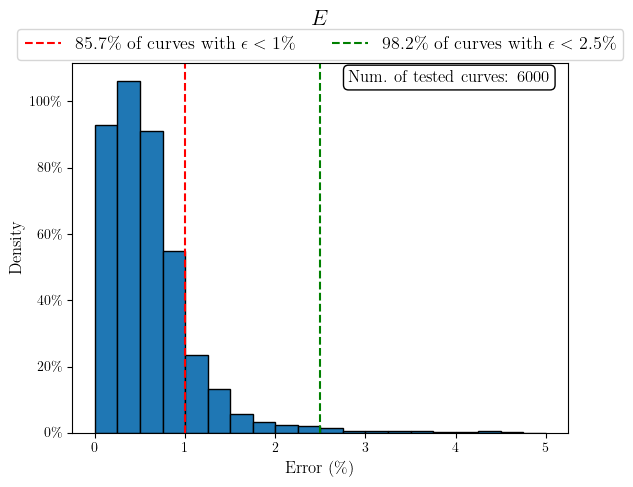

<Figure size 640x480 with 0 Axes>

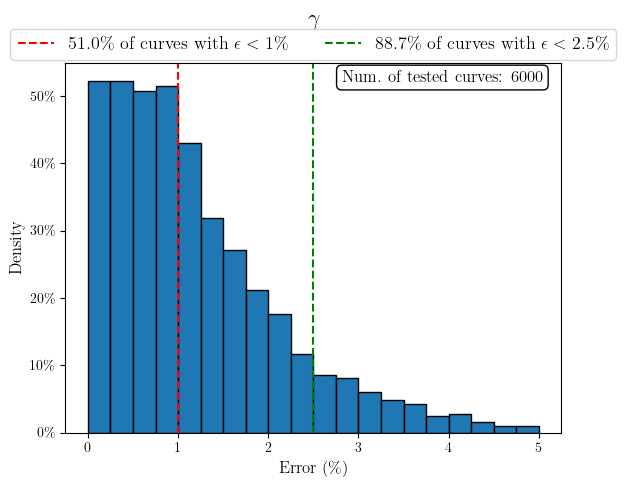

<Figure size 640x480 with 0 Axes>

torch.Size([16, 50, 2]) 375
{'model_name': 'Regression_JKR', 'model_loss': 0.0010314153057600682, 'model_error': 0.6609218432108561, 'under_1%_error': 0.8573333333333333, 'under_2.5%_error': 0.9815, 'under_5%_error': 0.9938333333333333, 'under_10%_error': 0.998}
{'model_name': 'Regression_JKR', 'model_loss': 0.000944491807759429, 'model_error': 1.2664503378868104, 'under_1%_error': 0.5103333333333333, 'under_2.5%_error': 0.8866666666666667, 'under_5%_error': 0.9878333333333333, 'under_10%_error': 0.9986666666666667}


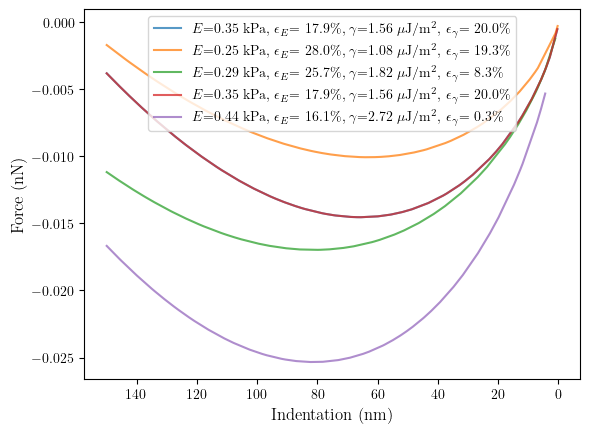

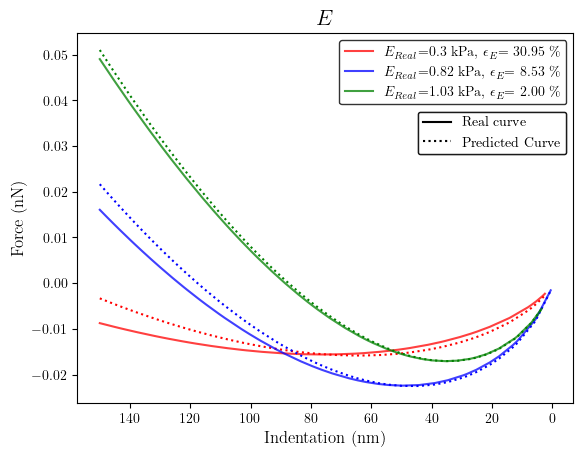

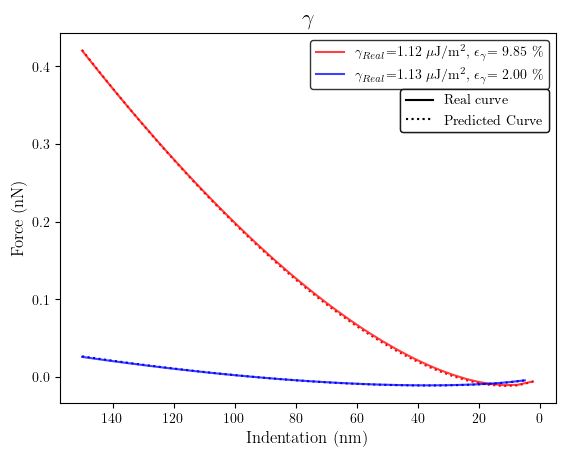

In [38]:
eval_model(loaded_model, test_loader, loss_fn, error_fn)

([<matplotlib.axis.XTick at 0x222fe1712a0>,
 [Text(20, 0, '$\\mathdefault{20}$'),
  Text(40, 0, '$\\mathdefault{40}$'),
  Text(60, 0, '$\\mathdefault{60}$')])

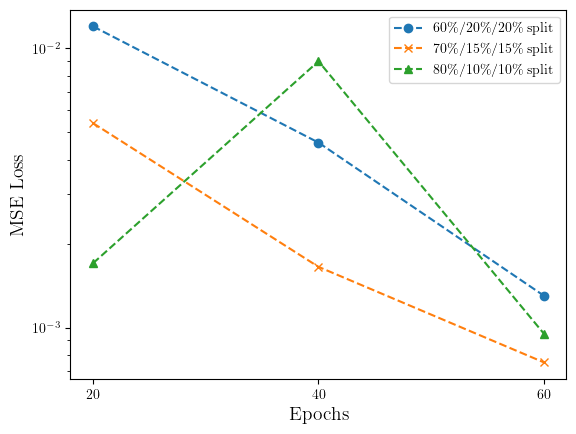

In [39]:
import matplotlib.pyplot as plt

# Boxplots overlayed
s60 = [0.012, 0.0046, 0.0013]
s70 = [0.0054, 0.00165, 0.00075]
s80 = [0.0017, 0.009, 0.00095]

x = [20,40,60]

plt.plot(x, s60, label="$60\%/20\%/20\%$ split", marker='o', linestyle='--')
plt.plot(x, s70, label="$70\%/15\%/15\%$ split", marker='x', linestyle='--')
plt.plot(x, s80, label="$80\%/10\%/10\%$ split", marker='^', linestyle='--')
plt.legend()


# y axis in log scale
plt.yscale('log')
# y label
plt.ylabel('MSE Loss', fontsize=14)
# x label
plt.xlabel('Epochs', fontsize=14)
# x ticks only for 20, 40 and 60
plt.xticks(x)